In [167]:
import torch
import torch.nn.functional as F
import numpy as np

In [65]:
# batch*n
def normalize_vector( v, return_mag =False):
    batch=v.shape[0]
    v_mag = torch.sqrt(v.pow(2).sum(1))# batch
    v_mag = v_mag.view(batch,1).expand(batch,v.shape[1])
    v = v/v_mag
    if(return_mag==True):
        return v, v_mag[:,0]
    else:
        return v

def transform_matrix_torch(axisAngle):
    
    batch = axisAngle.shape[0]
    batch,dim = axisAngle.shape
    axis = axisAngle[:,0:3]
    #axis_rotate = axisAngle[:,3:]
    axis_norm = normalize_vector(axis)
    #axis_rotate_norm = normalize_vector(axis_rotate)
    b1 = axis_norm[:,0]
    b2 = axis_norm[:,1]
    b3 = axis_norm[:,2]
    # Check for the specific input (0,0,1) and return identity matrix
    identity_mask = (b1 == 0) & (b2 == 0) & (b3 == 1)
    anti_identity_mask = (b1 == 0) & (b2 == 0) & (b3 == -1)
    identity_matrix = torch.eye(3, device=axisAngle.device).unsqueeze(0).repeat(axisAngle.shape[0], 1, 1)
    anti_identity_matrix = -identity_matrix
    print(identity_mask,anti_identity_mask)
    # Calculate matrix elements
    m00 = b3 + (b2**2 * (-1 + b3)) / (-1 + torch.abs(b3)**2)
    m01 = -(b1 * b2 * (-1 + b3)) / (-1 + torch.abs(b3)**2)
    m02 = b1
    
    m10 = -(b1 * b2 * (-1 + b3)) / (-1 + torch.abs(b3)**2)
    m11 = b3 + (b1**2 * (-1 + b3)) / (-1 + torch.abs(b3)**2)
    m12 = b2
    
    m20 = -b1 
    m21 = -b2
    m22 = b3
    
    # Stack the results to form the output matrix of shape (batch_size, 3, 3)
    output = torch.stack([
        torch.stack([m00, m01, m02], dim=-1),
        torch.stack([m10, m11, m12], dim=-1),
        torch.stack([m20, m21, m22], dim=-1)
    ], dim=1)
    
    # Replace the output with identity matrix where the input is (0,0,1)
    output[identity_mask] = identity_matrix[identity_mask]
    output[anti_identity_mask] = anti_identity_matrix[anti_identity_mask]
    
    return output


In [93]:
# Example usage:
input_data_torch = torch.tensor([[1,2,3],[0,0,1],[0,0,-1],[1,0,0],[0,1,0],[1,1,0],[1,0,1],[0,1,1]])
A=transform_matrix_torch(input_data_torch)[0]
#print(transform_matrix_torch(input_data_torch))

tensor([False,  True, False, False, False, False, False, False]) tensor([False, False,  True, False, False, False, False, False])


In [80]:
rot = transform_matrix_torch(input_data_torch)

tensor([False,  True,  True, False, False, False, False, False]) tensor([False, False, False, False, False, False, False, False])


In [97]:

vectors = torch.tensor([0,np.sqrt(2)/2,np.sqrt(2)/2]).unsqueeze(0).repeat(8,1).to(torch.float32)
print(vectors.shape)

torch.Size([8, 3])


In [98]:
# Perform batch matrix-vector multiplication
result = torch.bmm(rot, vectors.unsqueeze(-1)).squeeze(-1)
print(result)

tensor([[ 0.1329,  0.9729,  0.1890],
        [ 0.0000,  0.7071,  0.7071],
        [ 0.0000,  0.7071,  0.7071],
        [ 0.7071,  0.7071,  0.0000],
        [ 0.0000,  0.7071, -0.7071],
        [ 0.1464,  0.8536, -0.5000],
        [ 0.5000,  0.7071,  0.5000],
        [ 0.0000,  1.0000,  0.0000]])


In [109]:
a = {'name':'Adam','age':10}
print('name' in a)

True


In [105]:
vectors = torch.rand((8,6))
print(vectors.shape)
def s2s2_to_matrix(v1, v2=None):
    """
    Normalize 2 3-vectors. Project second to orthogonal component.
    Take cross product for third. Stack to form SO matrix.
    """
    if v2 is None:
        assert v1.shape[-1] == 6
        v2 = v1[..., 3:]
        v1 = v1[..., 0:3]
    u1 = v1
    e1 = u1 / u1.norm(p=2, dim=-1, keepdim=True).clamp(min=1E-5)
    u2 = v2 - (e1 * v2).sum(-1, keepdim=True) * e1
    e2 = u2 / u2.norm(p=2, dim=-1, keepdim=True).clamp(min=1E-5)
    e3 = torch.cross(e1, e2)
    return torch.cat([e1[..., None, :], e2[..., None, :], e3[..., None, :]], -2)
print(s2s2_to_matrix(vectors).shape)

torch.Size([8, 6])
torch.Size([8, 3, 3])


In [110]:
a.pop('age')

10

In [111]:
print(a)

{'name': 'Adam'}


In [117]:
def rar_to_matrix(axis,axis_rotate=None):
    batch_size, dim = axis.shape
    device = axis.device
    if axis_rotate is None:
        assert dim == 5
        axis_rotate = axis[:, 3:]
        axisAngle = axis[:, 0:3]

    # axis rotation
    axis_norm = normalize_vector(axis)
    b1 = axis_norm[:, 0]
    b2 = axis_norm[:, 1]
    b3 = axis_norm[:, 2]

    # rotation around the axis
    axis_rotate_norm = normalize_vector(axis_rotate)
    a1 = axis_rotate_norm[:, 0]
    a2 = axis_rotate_norm[:, 1]

    # Check for the specific input (0,0,1) and return identity matrix
    identity_mask = (b1 == 0) & (b2 == 0) & (b3 == 1)
    anti_identity_mask = (b1 == 0) & (b2 == 0) & (b3 == -1)
    identity_matrix = torch.eye(3, device=axis.device).unsqueeze(0).repeat(axis.shape[0], 1, 1)
    anti_identity_matrix = -identity_matrix
    # Calculate matrix elements
    m00 = b3 + (b2 ** 2 * (-1 + b3)) / (-1 + torch.abs(b3) ** 2)
    m01 = -(b1 * b2 * (-1 + b3)) / (-1 + torch.abs(b3) ** 2)
    m02 = b1

    m10 = -(b1 * b2 * (-1 + b3)) / (-1 + torch.abs(b3) ** 2)
    m11 = b3 + (b1 ** 2 * (-1 + b3)) / (-1 + torch.abs(b3) ** 2)
    m12 = b2

    m20 = -b1
    m21 = -b2
    m22 = b3

    # Stack the results to form the output matrix of shape (batch_size, 3, 3)
    M1 = torch.stack([
        torch.stack([m00, m01, m02], dim=-1),
        torch.stack([m10, m11, m12], dim=-1),
        torch.stack([m20, m21, m22], dim=-1)
    ], dim=1)

    # Replace the output with identity matrix where the input is (0,0,1)
    M1[identity_mask] = identity_matrix[identity_mask]
    M1[anti_identity_mask] = anti_identity_matrix[anti_identity_mask]

    ma00 = a1
    ma01 = a2
    ma02 = torch.zeros(batch_size).to(device)
    ma10 = -a2
    ma11 = a1
    ma12 = torch.zeros(batch_size).to(device)
    ma20 = torch.zeros(batch_size).to(device)
    ma21 = torch.zeros(batch_size).to(device)
    ma22 = torch.ones(batch_size).to(device)

    M2 = torch.stack([
        torch.stack([ma00, ma01, ma02], dim=-1),
        torch.stack([ma10, ma11, ma12], dim=-1),
        torch.stack([ma20, ma21, ma22], dim=-1)
    ], dim=1)

    output = torch.bmm(M2,M1)

    return output

In [185]:
def rotate_and_translate_3D(volumes, axes_xy, translations):
    # verified
    assert len(volumes.shape) == 5, "volumes tensor should be of size [B, C, D, H, W]"
    assert len(axes_xy.shape) == 3, "axes_xy tensor should be of size [B, 3, 2]"
    assert len(translations.shape) == 2, "translations tensor should be of size [B, 3]"

    device = volumes.device
    # Get size of the input images
    W = volumes.shape[-1]

    axes_xyz = axes_xy

    translations = translations / (W / 2)
    translations = torch.zeros(translations.shape).to(device)

    T = torch.cat([axes_xyz, translations.unsqueeze(2)], dim=2).to(device)

    grid = affine_grid_3d(T, volumes.size(), align_corners=False).to(device)
    # grid = F.affine_grid(T, volumes.size(), align_corners=False).to(device)

    # Sample from original images
    rotated_images = F.grid_sample(volumes, grid, mode='bilinear', align_corners=False)

    return rotated_images

def affine_grid_3d(theta, size, align_corners, device='cpu'):
    B, C, D, H, W = size

    base_grid = torch.zeros(B, D, H, W, 3, device=device)

    if align_corners:
        x = torch.linspace(-1, 1, W, device=device)
        y = torch.linspace(-1, 1, H, device=device)
        z = torch.linspace(-1, 1, D, device=device)
    else:
        x = torch.linspace(-1 + 1. / (W - 1), 1 - 1. / (W - 1), W, device=device)
        y = torch.linspace(-1 + 1. / (H - 1), 1 - 1. / (H - 1), H, device=device)
        z = torch.linspace(-1 + 1. / (D - 1), 1 - 1. / (D - 1), D, device=device)

    x, y, z = torch.meshgrid(x, y, z)
    base_grid[..., 0] = x.to(device)
    base_grid[..., 1] = y.to(device)
    base_grid[..., 2] = z.to(device)

    grid = base_grid.view(B, -1, 3)
    grid = torch.cat((grid, torch.ones(B, grid.shape[1], 1).to(device)), dim=2)

    grid = torch.bmm(grid, theta.transpose(1, 2))
    grid = grid.view(B, D, H, W, 3)
    
    return grid

In [273]:
axis_1 = torch.tensor([0,1,1]).unsqueeze(0).repeat(2,1)
axis_2 = torch.tensor([[0,1],[1,0]])

In [274]:
matrix=rar_to_matrix(axis_1,axis_2)
print(matrix[0])
R_diff=torch.bmm(matrix,torch.transpose(torch.flip(matrix,dims=(0,)),1,2))
regularization = torch.FloatTensor([0,0,1]).unsqueeze(0).expand(2,-1)
loss_R1=F.mse_loss(R_diff[:,-1],regularization)
print(loss_R1)

tensor([[ 0.0000,  0.7071,  0.7071],
        [-1.0000,  0.0000,  0.0000],
        [ 0.0000, -0.7071,  0.7071]])
tensor(1.1842e-15)


In [275]:
import mrcfile
volume_path='/net/jiang/scratch/li3221/simmicro/10340-tau/emd_10512.map'
with mrcfile.open(volume_path) as mrc:
    volume=mrc.data
volumes=torch.tensor(volume).unsqueeze(0).unsqueeze(0).repeat(2,1,1,1,1)

In [276]:
print(volumes.shape)

torch.Size([2, 1, 330, 330, 330])


In [277]:
volumes2 = rotate_and_translate_3D(volumes,matrix,torch.rand(2,3))

In [278]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'volume2')

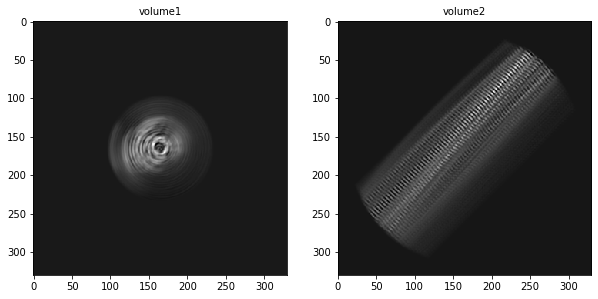

In [279]:
fig, axs = plt.subplots(ncols=2, squeeze=False, figsize=(10,20))
axs[0][0].imshow(volumes[0,0].mean(0),cmap='gray')
axs[0][0].set_title('volume1',size=10)
axs[0][1].imshow(volumes2[0,0].mean(0),cmap='gray')
axs[0][1].set_title('volume2',size=10)